In [2]:
import boto3
import awswrangler as wr
import pandas as pd
accessKeys = pd.read_csv("../../quant-bears_accessKeys.csv")
session = boto3.Session(
	aws_access_key_id=accessKeys.loc[0, "Access key ID"],
	aws_secret_access_key=accessKeys.loc[0, "Secret access key"]
)

s3_collection_path = "s3://quant-bears-data-collection/raw-data/"

In [3]:
df_alpha = wr.s3.read_parquet(s3_collection_path + "seekingAlpha.seekingAlphaBulkMetrics/2023-10-02.parquet", boto3_session=session)
df_guru = wr.s3.read_parquet(s3_collection_path + "gurufocus/2023-10-02.parquet", boto3_session=session)

In [4]:
df_guru["Avg_Volume__2M_"].describe()

count    1.576000e+03
mean     3.374992e+06
std      6.717153e+06
min      0.000000e+00
25%      8.779700e+05
50%      1.560000e+06
75%      3.102500e+06
max      1.142200e+08
Name: Avg_Volume__2M_, dtype: float64

In [5]:
df_guru["Volume"].describe()

count    1.576000e+03
mean     3.320476e+06
std      6.496050e+06
min      1.943600e+05
25%      8.353050e+05
50%      1.500000e+06
75%      3.152500e+06
max      1.216200e+08
Name: Volume, dtype: float64

In [6]:
df_guru[df_guru["Avg_Volume__2M_"] == 0.]

,symbol,Volume,Avg_Volume__2M_,Market_Cap,Enterprise_Value,growth_rank,3-Year_Revenue_Growth_Rate,3-Year_EBITDA_Growth_Rate,3-Year_EPS_without_NRI_Growth_Rate,3-Year_FCF_Growth_Rate,...,Price-to-Graham-Number,Earnings_Yield__Greenblatt__%,Forward_Rate_of_Return__Yacktman__%,sector,area,Price-to-DCF__Earnings_Based_,Price-to-DCF__FCF_Based_,Price-to-Net-Current-Asset-Value,Price-to-Net-Cash,Price-to-FFO
1215,SAFE,838630.0,0.0,1.090000e+09,5.530000e+09,0.1,-22.7,0.8,-23.6,NaN,...,NaN,-1.54,NaN,Real Estate,REITs,NaN,NaN,NaN,NaN,NaN


In [7]:
df_guru["Enterprise_Value"].describe()

count    1.576000e+03
mean     3.790269e+10
std      1.321883e+11
min     -2.879900e+11
25%      3.542500e+09
50%      9.250000e+09
75%      2.891000e+10
max      2.720000e+12
Name: Enterprise_Value, dtype: float64

In [8]:
df_guru.shape

(1576, 74)

In [9]:
df_guru["Market_Cap"]

0       3.245000e+10
1       5.150000e+09
2       8.330000e+09
3       3.210000e+09
4       2.720000e+12
            ...     
1571    2.369000e+10
1572    1.968000e+10
1573    7.951000e+10
1574    1.150000e+09
1575    4.700000e+09
Name: Market_Cap, Length: 1576, dtype: float64

In [10]:
ev_quantile_90 = df_guru["Enterprise_Value"].quantile(0.90)
ev_quantile_05 = df_guru["Enterprise_Value"].quantile(0.05)
adv_quantile_90 = df_guru["Avg_Volume__2M_"].quantile(0.90)
adv_quantile_05 = df_guru["Avg_Volume__2M_"].quantile(0.05)
ev_mask = (df_guru["Enterprise_Value"] < ev_quantile_90) & (df_guru["Enterprise_Value"] > ev_quantile_05)
adv_mask = (df_guru["Avg_Volume__2M_"] < adv_quantile_90) & (df_guru["Avg_Volume__2M_"] > adv_quantile_05)
robust_guru_df  = df_guru[ev_mask & adv_mask]

<Axes: xlabel='Enterprise_Value', ylabel='Avg_Volume__2M_'>

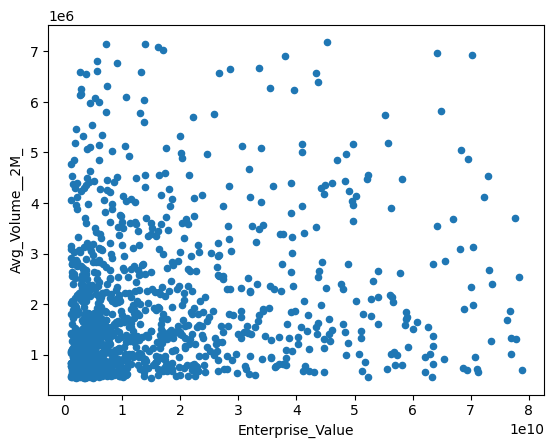

In [11]:
robust_guru_df.plot.scatter(x = "Enterprise_Value", y = "Avg_Volume__2M_")

<Axes: xlabel='sector'>

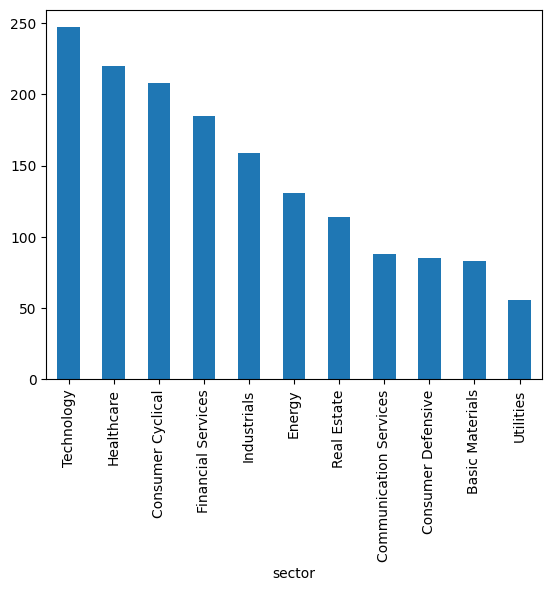

In [12]:
df_guru["sector"].value_counts().plot(kind="bar")
# Stratify by sector

In [13]:
df_guru = df_guru.set_index("symbol")
df_alpha = df_alpha.set_index("ticker")

In [14]:
joined_df = pd.concat([df_guru, df_alpha], axis = 1)
joined_df.shape

(1576, 337)

In [15]:
sectors = pd.get_dummies(joined_df["sector"]).astype("float").add_prefix("sector_")

In [16]:
joined_df = pd.concat([joined_df, sectors], axis = 1)

In [17]:
float_df = joined_df.select_dtypes([int, float])
float_df.shape

(1576, 346)

In [18]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    # plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    # plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)
    return fig

In [19]:
import scipy
import numpy as np
import scipy.cluster.hierarchy as sch

float_df = float_df.fillna(0.)

X = float_df.corr().values
d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [float_df.columns.tolist()[i] for i in list((np.argsort(ind)))]
float_df = float_df.reindex(columns = columns)

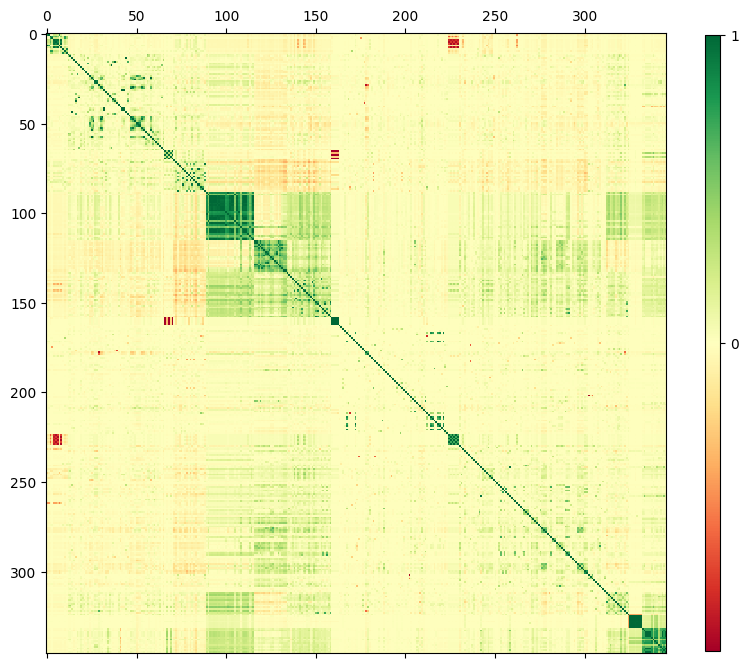

In [20]:
plot_corr(float_df)
pass

In [21]:
corr_df = float_df.corr().abs()

In [22]:
from tqdm import tqdm

In [23]:
cols_to_remove = set()
corr_threshold = .95

for col in tqdm(float_df.columns):
	if col in cols_to_remove:
		continue
	exceeded_values = corr_df.columns[(corr_df.loc[col] > corr_threshold)]
	if exceeded_values.shape[0] > 1:
		new_cols = set(exceeded_values.tolist())
		new_cols.remove(col)
		cols_to_remove = cols_to_remove.union(new_cols)
	

100%|██████████| 346/346 [00:00<00:00, 31818.22it/s]


In [24]:
len(cols_to_remove)

60

In [25]:
high_corr_filtered_df = float_df.drop(list(cols_to_remove), axis = 1)

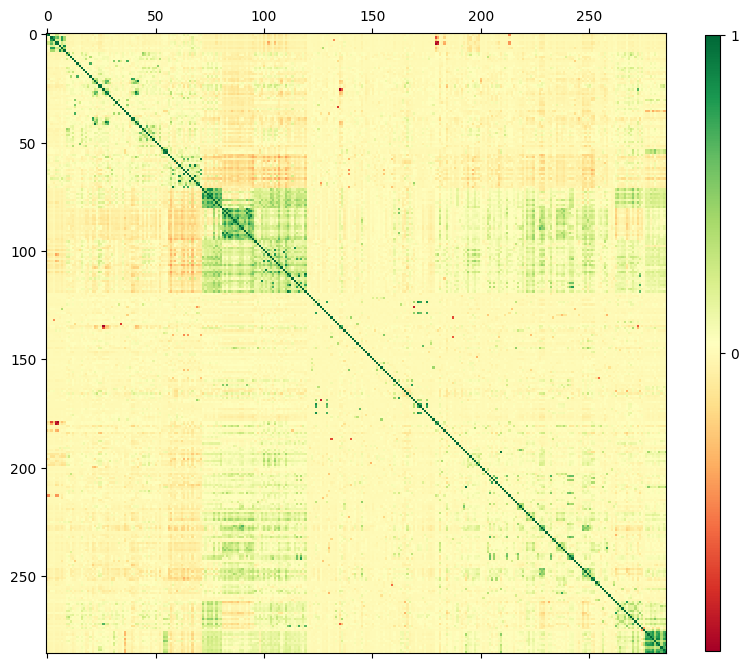

In [26]:
plot_corr(high_corr_filtered_df)
pass

In [27]:
high_corr_filtered_df.shape

(1576, 286)

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize, minmax_scale

In [29]:
minmax_df = pd.DataFrame(minmax_scale(high_corr_filtered_df), columns = high_corr_filtered_df.columns, index=high_corr_filtered_df.index)

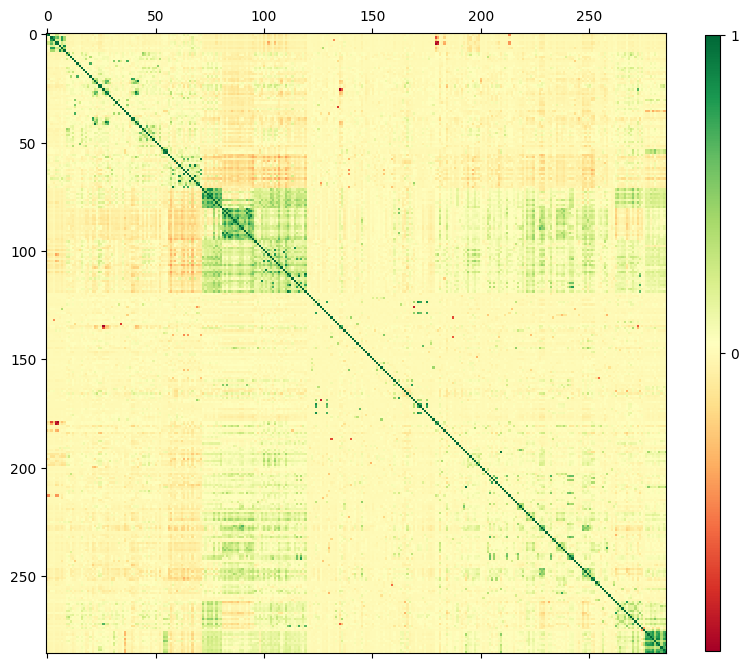

In [30]:
plot_corr(minmax_df)
pass

In [31]:
data = []
weights = []
biases = []
for col in tqdm(minmax_df.columns):
	X_ = minmax_df.copy()
	X_[col] = 0.
	y = minmax_df[col]
	linreg = LinearRegression()
	linreg.fit(X_, y)
	y_pred = linreg.predict(X_)
	y_residual = y - y_pred
	data.append(y_residual)
	weights.append(linreg.coef_)
	biases.append(linreg.intercept_)

100%|██████████| 286/286 [01:57<00:00,  2.43it/s]


In [32]:
residual_df = pd.DataFrame(data, index = minmax_df.columns).T
residual_df.head()

,ev_sales_fy1,EV-to-Forward-Revenue,capex_to_sales,capex_change_avg_5y,ps_ratio,PS_Ratio,Days_Payable,revenue_change_display,Days_Inventory,cf_op_change_display_avg_5y,...,cash_from_operations_as_reported,cash_from_operations_as_reported_avg_5y,Market_Cap,ebitda,authors_count,levered_free_cash_flow,net_income,number_of_employees,total_revenue,gross_profit
A,-0.000600,0.001249,0.000358,0.000559,0.002641,-0.000572,0.001189,0.000753,-0.000413,-0.001041,...,0.008749,0.010089,-0.002082,-0.005301,0.024237,-0.003177,-0.003710,-0.001710,-0.001536,0.006413
AA,-0.001635,0.005393,-0.002162,0.002878,0.004770,-0.003151,-0.007999,-0.000564,0.004205,-0.027123,...,0.005179,-0.008562,0.009548,-0.004929,-0.013615,0.000156,-0.004165,-0.003448,-0.004323,0.007450
AAL,-0.003558,-0.001263,0.000094,0.001294,0.002729,-0.001607,0.003948,-0.003848,-0.002878,0.016793,...,-0.009912,-0.016120,-0.023585,0.008283,-0.009194,0.011149,0.007296,0.011594,0.014629,-0.010990
AAP,0.002785,-0.001309,0.000357,0.000682,0.001180,-0.000315,-0.002337,-0.000751,0.003981,0.001401,...,-0.009280,-0.024614,0.031936,-0.010072,0.031324,-0.015817,-0.005496,-0.018541,-0.000256,0.018123
AAPL,0.002121,-0.001228,-0.000271,0.001901,0.003530,-0.002003,0.001301,-0.002083,-0.002003,0.003078,...,-0.020615,0.034836,0.154694,-0.045700,-0.067335,0.131054,0.068985,-0.000303,0.060466,-0.106256


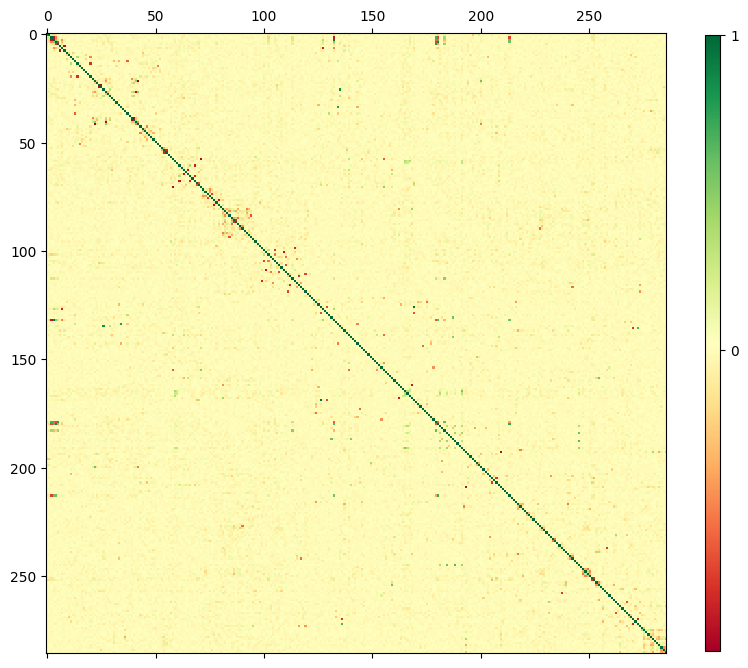

In [33]:
plot_corr(residual_df)
pass

In [34]:
residual_df.corrwith(minmax_df).sort_values(ascending = False).describe()

count    286.000000
mean       0.547386
std        0.270845
min       -0.346319
25%        0.334041
50%        0.560729
75%        0.768083
max        0.975655
dtype: float64

In [35]:
coef_df = pd.DataFrame(weights, columns = minmax_df.columns, index = "coefs_for_" + minmax_df.columns).T
coef_df.tail()

,coefs_for_ev_sales_fy1,coefs_for_EV-to-Forward-Revenue,coefs_for_capex_to_sales,coefs_for_capex_change_avg_5y,coefs_for_ps_ratio,coefs_for_PS_Ratio,coefs_for_Days_Payable,coefs_for_revenue_change_display,coefs_for_Days_Inventory,coefs_for_cf_op_change_display_avg_5y,...,coefs_for_cash_from_operations_as_reported,coefs_for_cash_from_operations_as_reported_avg_5y,coefs_for_Market_Cap,coefs_for_ebitda,coefs_for_authors_count,coefs_for_levered_free_cash_flow,coefs_for_net_income,coefs_for_number_of_employees,coefs_for_total_revenue,coefs_for_gross_profit
levered_free_cash_flow,-0.004166,0.008418,-0.003702,0.000253,-0.002601,0.004046,0.011797,0.007225,-0.006019,0.003944,...,0.040136,-0.041882,0.172463,0.228449,0.103609,4.857226e-17,4.815063e-02,-1.275631e-01,0.174572,0.014446
net_income,0.010976,-0.014074,-0.006039,0.006612,0.008374,-0.002036,0.009628,-0.015239,-0.003510,0.003593,...,0.153248,0.081448,0.448115,0.334679,0.154175,8.527885e-02,-6.938894e-18,-2.241706e-01,0.066368,0.037057
number_of_employees,-0.005547,0.009058,-0.001227,0.001374,0.002272,-0.001604,-0.000406,-0.000078,0.000343,-0.023144,...,-0.065171,0.030365,0.071078,-0.144657,-0.072107,-9.088451e-02,-9.015533e-02,7.806256e-18,0.462286,0.249047
total_revenue,0.005256,-0.006778,0.001354,-0.001693,-0.003115,-0.000449,0.001879,0.006582,-0.004269,0.002090,...,0.041438,0.017113,-0.138615,0.068532,0.052880,1.177020e-01,2.527046e-02,4.375650e-01,0.000000,0.215721
gross_profit,0.018200,-0.017864,0.001326,-0.001101,-0.003646,0.004383,0.009479,-0.000964,-0.004380,0.049515,...,0.157252,0.064821,0.117628,0.372987,-0.003528,2.204056e-02,3.196266e-02,5.341042e-01,0.488790,0.000000


In [36]:
intercept_series = pd.Series(biases, index = "intercepts_for_" + minmax_df.columns)

In [37]:
intercept_series

intercepts_for_ev_sales_fy1              1.223635e+10
intercepts_for_EV-to-Forward-Revenue    -3.164577e+10
intercepts_for_capex_to_sales            5.733475e+08
intercepts_for_capex_change_avg_5y      -8.320956e+11
intercepts_for_ps_ratio                  8.482547e+11
                                             ...     
intercepts_for_levered_free_cash_flow   -3.027860e+10
intercepts_for_net_income                4.940780e+10
intercepts_for_number_of_employees       6.716833e+09
intercepts_for_total_revenue             1.611548e+10
intercepts_for_gross_profit              9.037462e+09
Length: 286, dtype: float64

In [38]:
corr_df.abs().mean().sort_values().head(30)

levered_free_cash_flow_yoy           0.010205
sustainable_growth_rate              0.012115
pe_ratio                             0.012208
diluted_eps_growth_avg_5y            0.012406
peg_gaap_avg_5y                      0.012608
degree_of_operating_leverage_ttm     0.013195
levered_free_cash_flow_yoy_avg_5y    0.013218
peg_gaap                             0.013266
dividend_coverage_ratio_ttm          0.013490
eps_gaap_annual_growth_yoy           0.013930
ebitda_yoy_avg_5y                    0.014772
op_cf_yoy                            0.014839
working_cap_change                   0.014983
ebitda_yoy                           0.014989
EV-to-EBIT                           0.015088
rtn_on_common_equity_avg_5y          0.015326
pb_ratio_avg_5y                      0.015403
capex_change                         0.015502
operating_income_ebit_yoy            0.015556
debt_eq                              0.015629
capm_alpha_60m                       0.015994
EV-to-FCF                         

In [39]:
joined_df.columns[joined_df.columns.str.lower().str.contains("debt")]

Index(['debt_eq', 'debt_eq_avg_5y', 'net_lt_debt_ebitda',
       'net_lt_debt_ebitda_avg_5y', 'net_lt_debt_tot_assets',
       'net_lt_debt_tot_assets_avg_5y', 'tot_debt_cap', 'tot_debt_cap_avg_5y',
       'total_debt'],
      dtype='object')

In [40]:
joined_df["tot_debt_cap"].isna().sum()

79

In [41]:
joined_df["dividend_coverage_ratio_ttm"].isna().sum()

640

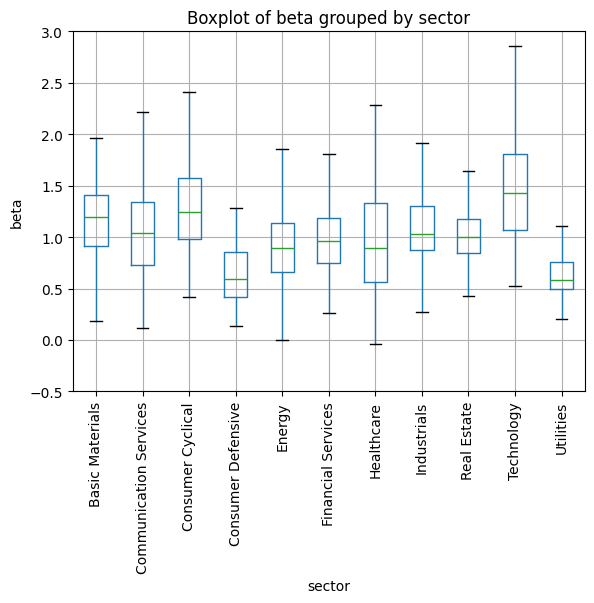

In [45]:
import matplotlib.pyplot as plt
joined_df.boxplot(by="sector", column = "beta24", showfliers=False)
plt.suptitle('')
plt.xticks(rotation = 90)
plt.ylim((-0.5, 3))
plt.ylabel("beta")
plt.title("Boxplot of beta grouped by sector")
pass

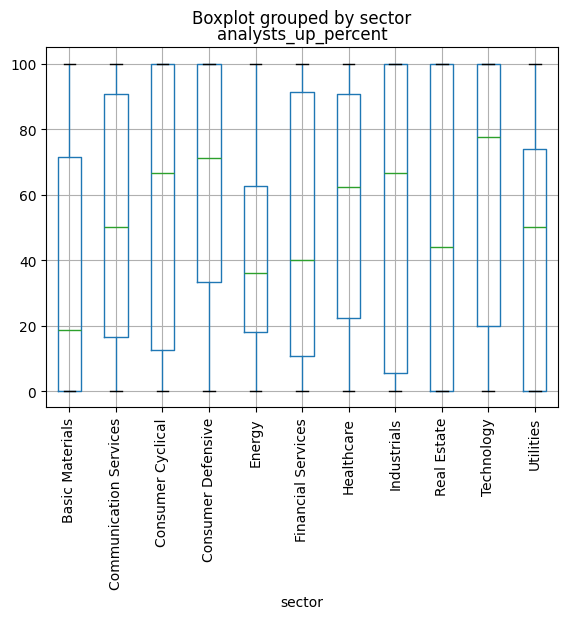

In [43]:
import matplotlib.pyplot as plt
joined_df.boxplot(by="sector", column = "analysts_up_percent", showfliers=False)
plt.xticks(rotation = 90)
pass

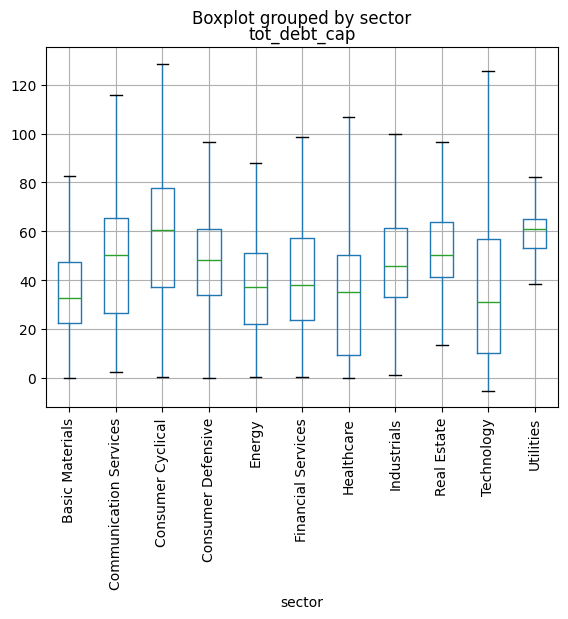

In [227]:
import matplotlib.pyplot as plt
joined_df.boxplot(by="sector", column = "tot_debt_cap", showfliers=False)
plt.xticks(rotation = 90)
pass

In [230]:
joined_df["short_interest_percent_of_float"].isna().sum()

174

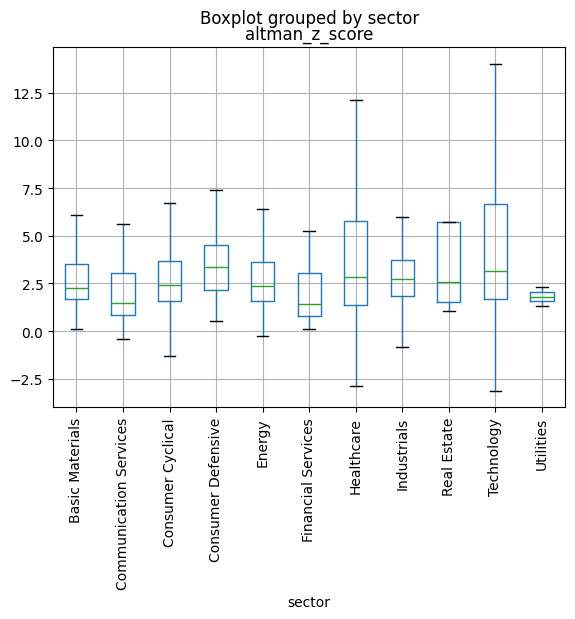

In [229]:
import matplotlib.pyplot as plt
joined_df.boxplot(by="sector", column = "altman_z_score", showfliers=False)
plt.xticks(rotation = 90)
pass

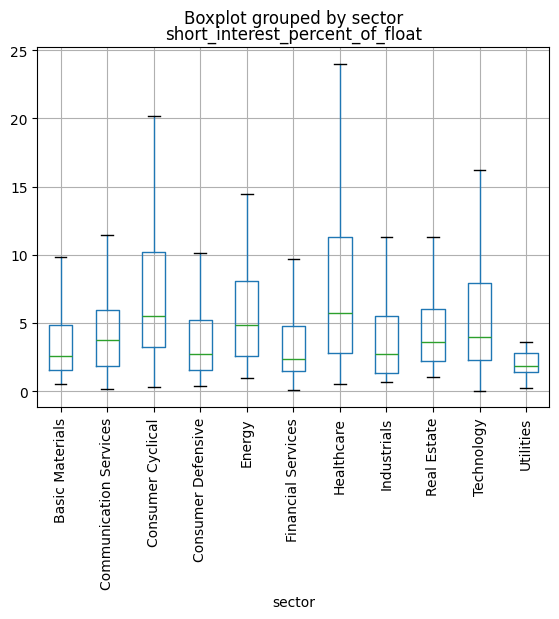

In [231]:
import matplotlib.pyplot as plt
joined_df.boxplot(by="sector", column = "short_interest_percent_of_float", showfliers=False)
plt.xticks(rotation = 90)
pass

In [ ]:
# Autocorrelation plot